### Import Statements

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
import astropy.constants as c

%matplotlib inline

### Search For Tess Cutout of Target

In [2]:
ticid = 38305527 
starName = "TIC " + str(ticid)
search_result = lk.search_targetpixelfile(starName)

In [3]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 03,2014,K2,60,ktwo206292760,0.0
1,K2 Campaign 03,2014,K2,1800,ktwo206292760,0.0
2,TESS Sector 42,2021,SPOC,20,38305527,0.0
3,TESS Sector 42,2021,SPOC,120,38305527,0.0
4,TESS Sector 42,2021,TESS-SPOC,600,38305527,0.0


### Download File

In [4]:
tpf = search_result[1].download(quality_bitmask='hard')

### Create Aperture of Pixels 1.5 Times Above Median Flux and Plot

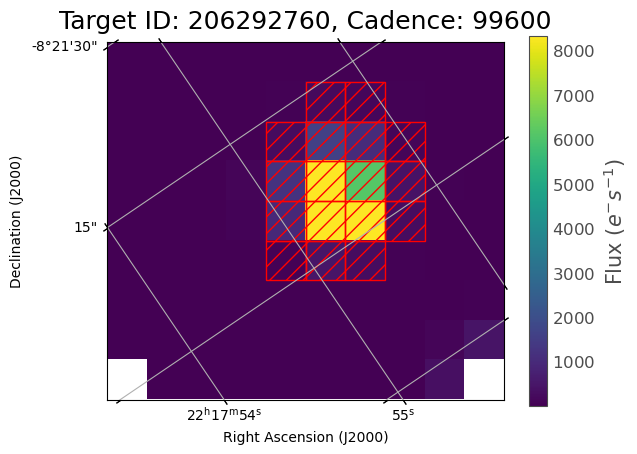

In [5]:
aperture_mask = tpf.create_threshold_mask(threshold=5)

fig, ax = plt.subplots(subplot_kw={'projection': tpf.wcs})  # Use WCS projection
tpf.plot(ax=ax, aperture_mask=aperture_mask)  # Plot TPF imag

#Label axes with RA/Dec
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.show()

### Create Light Curve

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

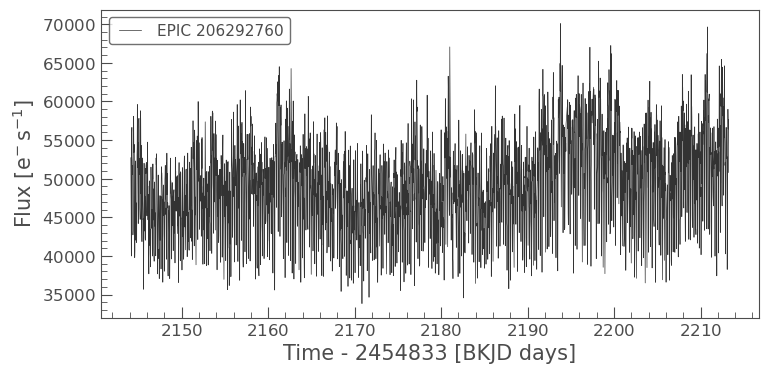

In [6]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
uncorrected_lc.plot()

### Estimate Background

In [7]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

In [8]:
# Replace NaNs in flux with 0s or a suitable value
tpf_flux_clean = np.nan_to_num(tpf.flux)

In [9]:
bkgAperture = ~aperture_mask  # Invert the aperture mask correctly

bkgFlux = make_lc(tpf_flux_clean.value, bkgAperture)
time = uncorrected_lc.time.value

Text(0.5, 1.0, 'Background Flux')

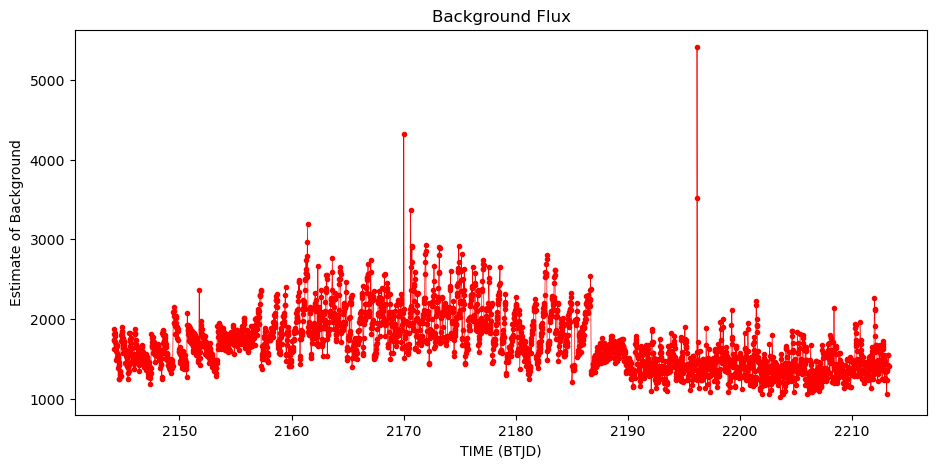

In [10]:
plt.figure(figsize = (11, 5))
plt.plot(time, bkgFlux, 'r.-', lw = .5)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Text(0.5, 1.0, 'Background Subtracted Flux FO Aquarii Sector 42')

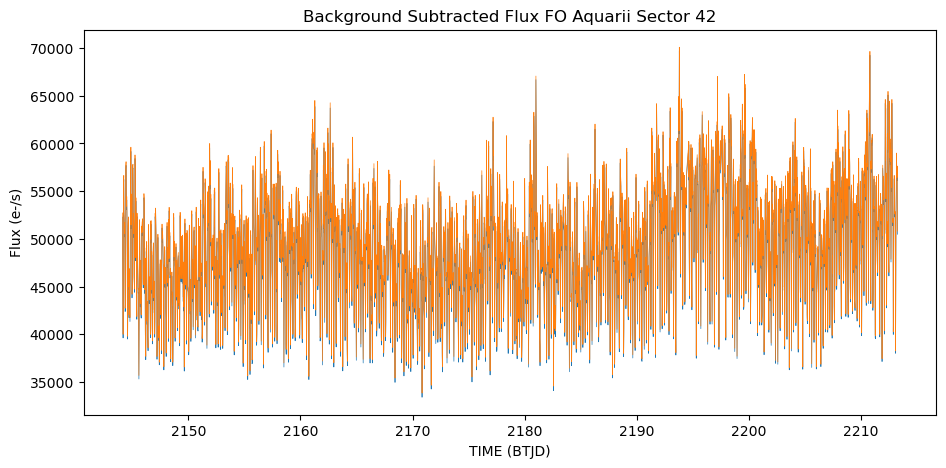

In [13]:
corrected_lc = uncorrected_lc.flux.value - (bkgFlux * np.sum(aperture_mask) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time, corrected_lc, lw = 0.5)
plt.plot(uncorrected_lc.time.value, uncorrected_lc.flux.value, lw=0.5)

plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux FO Aquarii Sector 42')
#plt.xlim(2150, 2151)

#for spin period xlim(2150, 2150.14)

In [ ]:
time_btjd = tpf.time.value

time_jd = time_btjd + 2457000

# Convert to a readable format (e.g., ISO)
from astropy.time import Time
time_iso = Time(time_jd, format='jd').iso

print(time_iso[0]) 
print(time_iso[-1])

In [ ]:
a = time
b = corrected_lc
c = uncorrected_lc.flux_err.value

fo_aquarii1 = np.vstack([a,b,c])

np.savetxt("fo_aquarii1.csv", fo_aquarii1, delimiter=",", fmt="%s")